## Full resolution

In [1]:
from dataset import get_mnist_dataset
train_set, train_classes = get_mnist_dataset(train=True, shuffle=True, normalize=False)
val_set, val_classes = get_mnist_dataset(train=False, total_data=1000, shuffle=True, normalize=False)

train_set = train_set.view(train_set.shape[0], train_set.shape[1], -1)
val_set = val_set.view(val_set.shape[0], val_set.shape[1], -1)

from collections import OrderedDict, namedtuple
from itertools import product
import os
from tqdm import tqdm, trange
from IPython.display import clear_output
import time
import torch.nn as nn
import pandas as pd
import torch
import matplotlib.pyplot as plt
from utils.run_manager import RunBuilder
from models import g_step, MnistAEDGCCA, MnistAELinear
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import torchvision
from dataset import get_mnist_dataset 
import numpy as np

class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

if torch.cuda.is_available():
    devices = ['cpu']
else:
    devices = ['cpu']
print('starting')


params = OrderedDict(
    lr = [0.0001],
    batch_size = [1000],
    device = devices,
    shuffle = [True],
    num_workers = [5],
    manual_seed = [1265],
    loss_func = [nn.MSELoss],
    quant = [True],
    latent_dim = [10], 
    num_inner_epochs = [1],
    n_bits = [2]
)

# layer_sizes_list = 3*[[128, 64, 2]]
# input_size_list = 3*[2]


run_count = 0
models = []


run_data = []

data_load_time = 0
forward_time = 0


for run in RunBuilder.get_runs(params):
#     torch.cuda.set_device(run.device)
    
    run_count += 1
    device = torch.device(run.device)
    
    dgcca = MnistAEDGCCA(output_size=run.latent_dim, network=MnistAELinear)
    dgcca = dgcca.to('cpu')
        
    train_views = list(train_set.to('cpu'))
    val_views = list(val_set.to('cpu'))
    
    optimizer = torch.optim.Adam(dgcca.parameters(), lr=run.lr)
    num_batches = len(train_views[0])//run.batch_size
    
    criterion = run.loss_func()

    out = torch.stack(dgcca(train_views))
    G = g_step(out.clone().detach())  
    
    M_serv = out.detach().clone()
    
    I = len(train_views)
    
    for epoch in range(60):
        total_recons_loss = 0
        total_val_loss = 0
        batch_count = 0

        dgcca.train()
        dgcca.to('cuda')
        
        for _ in trange(run.num_inner_epochs):
            for i in trange(num_batches):

                optimizer.zero_grad()
                batch = []

                # mini batch gradient
                batch = [view[(i*run.batch_size):((i+1)*run.batch_size), :].to('cuda') for view in train_views]            
                target = G[(i*run.batch_size):((i+1)*run.batch_size), :].to('cuda')

                latent = dgcca(batch)

                ae_loss = (run.latent_dim/(2*28*28*target.shape[0]))*torch.norm(torch.stack(dgcca.decode(latent)) - torch.stack(batch))
    
                dgcca_loss = 1/2*torch.norm(torch.stack(latent)-target)/target.shape[0] 

                loss = dgcca_loss + ae_loss

                loss.backward()

                optimizer.step()

                total_recons_loss += loss.item()
                del batch, target, latent

        dgcca.eval()
        dgcca.to('cpu')
        out = torch.stack(dgcca(train_views)).detach().clone()        
        if run.quant:
            for i in range(I):
                diff = out[i] - M_serv[i]
                max_val = diff.abs().max()
                quant = ((1/max_val)*diff[i]).round()*(max_val/1)
                var = M_serv[i] + quant
                M_serv[i] = var
                del max_val, diff, quant, var
            G = g_step(M_serv.clone().detach())
        else:
            G = g_step(out.clone().detach())   
            
        # validation loss
        out_val = dgcca(val_views)
        out_val = torch.stack(out_val)
        
        G_val = g_step(out_val.clone().detach())
        
        
        loss_val = criterion(out_val, G_val)
        total_val_loss += loss_val.item()
        del out, G_val, out_val

        
        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['data_fidelity'] = total_recons_loss/(num_batches*run.num_inner_epochs)
        results['val_fidelity'] = total_val_loss
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        results['device'] = run.device
        
#         if results['data_fidelity'] < 0.00275:
#             break
        
        run_data.append(results)
        df3 = pd.DataFrame.from_dict(run_data, orient='columns')
        clear_output(wait=True)
#         show_latent()
        display(df3)
            
#             m.track_loss(G_adv_loss=losses['beta_kl-divergence'], G_mse_loss=losses[''], D_real_loss=total_D_real, D_fake_loss=total_D_fake, D_real_count=real_count, D_fake_count=fake_count)
#         print(epoch, "total_Gloss:",total_Gloss, "total_Dloss:",total_Dloss, "mse:",total_mse_loss, "adv: ", total_adv_loss)           
#         m.end_epoch()
        torch.save(dgcca, 'trained_models/dgcca_mnist_linear5_innerit1.model')

,run_count,epoch,data_fidelity,val_fidelity,batch_size,lr,device
0,1,0,0.006355,0.000932,1000,0.0001,cpu
1,1,1,0.003814,0.000948,1000,0.0001,cpu
2,1,2,0.003763,0.000926,1000,0.0001,cpu
3,1,3,0.003758,0.000908,1000,0.0001,cpu
4,1,4,0.003750,0.000921,1000,0.0001,cpu
5,1,5,0.003746,0.000906,1000,0.0001,cpu
6,1,6,0.003740,0.000914,1000,0.0001,cpu
7,1,7,0.003740,0.000894,1000,0.0001,cpu
8,1,8,0.003736,0.000913,1000,0.0001,cpu
9,1,9,0.003736,0.000902,1000,0.0001,cpu


## Quantized DGCCA on MNIST 

In [1]:
from dataset import get_mnist_dataset
train_set, train_classes = get_mnist_dataset(train=True, shuffle=True, normalize=False)
val_set, val_classes = get_mnist_dataset(train=False, total_data=1000, shuffle=True, normalize=False)

train_set = train_set.view(train_set.shape[0], train_set.shape[1], -1)
val_set = val_set.view(val_set.shape[0], val_set.shape[1], -1)

from collections import OrderedDict, namedtuple
from itertools import product
import os
from tqdm import tqdm, trange
from IPython.display import clear_output
import time
import torch.nn as nn
import pandas as pd
import torch
import matplotlib.pyplot as plt
from utils.run_manager import RunBuilder
from models import g_step, MnistAEDGCCA, MnistAELinear
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import torchvision
from dataset import get_mnist_dataset 
import numpy as np

class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

if torch.cuda.is_available():
    devices = ['cpu']
else:
    devices = ['cpu']
print('starting')


params = OrderedDict(
    lr = [0.001],
    batch_size = [1000],
    device = devices,
    shuffle = [True],
    num_workers = [5],
    manual_seed = [1265],
    loss_func = [nn.MSELoss],
    quant = [False],
    latent_dim = [10], 
    num_inner_epochs = [1]
)

# layer_sizes_list = 3*[[128, 64, 2]]
# input_size_list = 3*[2]


run_count = 0
models = []


run_data = []

data_load_time = 0
forward_time = 0


for run in RunBuilder.get_runs(params):
#     torch.cuda.set_device(run.device)
    
    run_count += 1
    device = torch.device(run.device)
    
    dgcca = MnistAEDGCCA(output_size=run.latent_dim, network=MnistAELinear)
    dgcca = dgcca.to('cpu')
        
    train_views = list(train_set.to('cpu'))
    val_views = list(val_set.to('cpu'))
    
    optimizer = torch.optim.Adam(dgcca.parameters(), lr=run.lr)
    num_batches = len(train_views[0])//run.batch_size
    
    criterion = run.loss_func()

    out = torch.stack(dgcca(train_views))
    G = g_step(out.clone().detach())  
    
    M_serv = out.detach().clone()
    
    I = len(train_views)
    
    for epoch in range(60):
        total_recons_loss = 0
        total_val_loss = 0
        batch_count = 0
        total_ae_loss = 0
        total_dgcca_loss = 0
        
        dgcca.train()
        dgcca.to('cuda')
        
        for _ in trange(run.num_inner_epochs):
            for i in trange(num_batches):

                optimizer.zero_grad()
                batch = []

                # mini batch gradient
                batch = [view[(i*run.batch_size):((i+1)*run.batch_size), :].to('cuda') for view in train_views]            
                target = G[(i*run.batch_size):((i+1)*run.batch_size), :].to('cuda')

                latent = dgcca(batch)

                ae_loss = (run.latent_dim/(2*28*28*target.shape[0]))*torch.norm(torch.stack(dgcca.decode(latent)) - torch.stack(batch))
                
                dgcca_loss = 1/2*torch.norm(torch.stack(latent)-target)/target.shape[0] 

                loss = dgcca_loss + ae_loss

                loss.backward()

                optimizer.step()

                total_recons_loss += loss.item()
                total_ae_loss += ae_loss.item()
                total_dgcca_loss += dgcca_loss.item()
                del batch, target, latent
        
        dgcca.eval()
        dgcca.to('cpu')
        out = torch.stack(dgcca(train_views)).detach().clone()        
        if run.quant:
            for i in range(I):
                diff = out[i] - M_serv[i]
                max_val = diff.abs().max()
                quant = ((1/max_val)*diff[i]).round()*(max_val/1)
                var = M_serv[i] + quant
                M_serv[i] = var
                del max_val, diff, quant, var
            G = g_step(M_serv.clone().detach())
        else:
            G = g_step(out.clone().detach())   
            
        # validation loss
        out_val = dgcca(val_views)
        out_val = torch.stack(out_val)
        
        G_val = g_step(out_val.clone().detach())
        
        
        loss_val = 1/2*torch.norm(out_val-G_val)/G_val.shape[0]
        total_val_loss += loss_val.item()
        del out, G_val, out_val

        
        results = OrderedDict()
        results['epoch'] = epoch
        results['total_loss'] = total_recons_loss/(num_batches*run.num_inner_epochs)
        results['ae_loss'] = total_ae_loss/(num_batches*run.num_inner_epochs)
        results['dgcca_loss'] = total_dgcca_loss/(num_batches*run.num_inner_epochs)
        results['val_fidelity'] = total_val_loss
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        
#         if results['data_fidelity'] < 0.00275:
#             break
        
        run_data.append(results)
        df3 = pd.DataFrame.from_dict(run_data, orient='columns')
        clear_output(wait=True)
#         show_latent()
        display(df3)
            
#             m.track_loss(G_adv_loss=losses['beta_kl-divergence'], G_mse_loss=losses[''], D_real_loss=total_D_real, D_fake_loss=total_D_fake, D_real_count=real_count, D_fake_count=fake_count)
#         print(epoch, "total_Gloss:",total_Gloss, "total_Dloss:",total_Dloss, "mse:",total_mse_loss, "adv: ", total_adv_loss)           
#         m.end_epoch()
        torch.save(dgcca, 'trained_models/dgcca_mnist_linear8_innerit1.model')

,epoch,total_loss,ae_loss,dgcca_loss,val_fidelity,batch_size,lr
0,0,0.012688,0.003427,0.009261,0.003522,1000,0.001
1,1,0.005458,0.003353,0.002105,0.003213,1000,0.001
2,2,0.005437,0.003350,0.002087,0.002929,1000,0.001
3,3,0.005254,0.003348,0.001905,0.002973,1000,0.001
4,4,0.005636,0.003348,0.002288,0.002803,1000,0.001
5,5,0.005409,0.003348,0.002062,0.002860,1000,0.001
6,6,0.005572,0.003347,0.002225,0.002944,1000,0.001
7,7,0.005564,0.003347,0.002216,0.002873,1000,0.001
8,8,0.006022,0.003347,0.002674,0.003381,1000,0.001
9,9,0.005640,0.003347,0.002292,0.002840,1000,0.001


In [6]:
# from dataset import get_mnist_dataset
# train_set, train_classes = get_mnist_dataset(train=True, shuffle=True, normalize=False)
# val_set, val_classes = get_mnist_dataset(train=False, total_data=1000, shuffle=True, normalize=False)

# train_set = train_set.view(train_set.shape[0], train_set.shape[1], -1)
# val_set = val_set.view(val_set.shape[0], val_set.shape[1], -1)

from collections import OrderedDict, namedtuple
from itertools import product
import os
from tqdm import tqdm, trange
from IPython.display import clear_output
import time
import torch.nn as nn
import pandas as pd
import torch
import matplotlib.pyplot as plt
from utils.run_manager import RunBuilder
from models import g_step, MnistAEDGCCA, MnistAELinear, MnistAELinearBN
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import torchvision
from dataset import get_mnist_dataset 
import numpy as np

from torch.optim.lr_scheduler import MultiStepLR

class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

if torch.cuda.is_available():
    devices = ['cpu']
else:
    devices = ['cpu']
print('starting')


params = OrderedDict(
    lr = [0.001],
    batch_size = [1000],
    device = devices,
    shuffle = [True],
    num_workers = [5],
    manual_seed = [1265],
    loss_func = [nn.MSELoss],
    quant = [False],
    latent_dim = [10], 
    num_inner_epochs = [1]
)

# layer_sizes_list = 3*[[128, 64, 2]]
# input_size_list = 3*[2]


run_count = 0
models = []


run_data = []

data_load_time = 0
forward_time = 0
n_levels = 1
diff_norm = 0

for run in RunBuilder.get_runs(params):
#     torch.cuda.set_device(run.device)
    
    run_count += 1
    device = torch.device(run.device)
    
    dgcca = MnistAEDGCCA(output_size=run.latent_dim, network=MnistAELinear)
    dgcca = dgcca.to('cpu')
        
    train_views = list(train_set.to('cpu'))
    val_views = list(val_set.to('cpu'))
    
    optimizer = torch.optim.Adam(dgcca.parameters(), lr=run.lr)
    scheduler = MultiStepLR(optimizer, [30,70], gamma=0.8)
    num_batches = len(train_views[0])//run.batch_size
    
    criterion = run.loss_func()

    out = torch.stack(dgcca(train_views))
    G = g_step(out.clone().detach())  
    
    M_serv = out.detach().clone()
    
    I = len(train_views)
    
    for epoch in range(150):
        total_recons_loss = 0
        total_val_loss = 0
        batch_count = 0
        total_ae_loss = 0
        total_dgcca_loss = 0
        
        dgcca.train()
        dgcca.to('cuda')
        
        for _ in trange(run.num_inner_epochs):
            for i in trange(num_batches):

                optimizer.zero_grad()
                batch = []

                # mini batch gradient
                batch = [view[(i*run.batch_size):((i+1)*run.batch_size), :].to('cuda') for view in train_views]            
                target = G[(i*run.batch_size):((i+1)*run.batch_size), :].to('cuda')

                latent = dgcca(batch)

                ae_loss = (run.latent_dim/(2*28*28*target.shape[0]))*torch.norm(torch.stack(dgcca.decode(latent)) - torch.stack(batch))
                
                dgcca_loss = 1/2*torch.norm(torch.stack(latent)-target)/target.shape[0] 

                loss = dgcca_loss + 0.1*ae_loss

                loss.backward()

                optimizer.step()

                total_recons_loss += loss.item()
                total_ae_loss += ae_loss.item()
                total_dgcca_loss += dgcca_loss.item()
                del batch, target, latent
        
        scheduler.step()
        
        dgcca.eval()
        dgcca.to('cpu')
        out = torch.stack(dgcca(train_views)).detach().clone()        
        if run.quant:
            for i in range(I):
                diff = out[i] - M_serv[i]
                max_val = diff.abs().max()
                quant = ((1/max_val)*diff[i]).round()*(max_val/1)
                var = M_serv[i] + quant
                M_serv[i] = var
                diff_norm = torch.norm(diff, 'fro')
                del max_val, diff, quant, var
            G = g_step(M_serv.clone().detach())
        else:
            G = g_step(out.clone().detach())   
            
        # validation loss
        out_val = dgcca(val_views)
        out_val = torch.stack(out_val)
        
        G_val = g_step(out_val.clone().detach())
        
        
        loss_val = 1/2*torch.norm(out_val-G_val)/G_val.shape[0]
        total_val_loss += loss_val.item()
        del out, G_val, out_val

        
        results = OrderedDict()
        results['epoch'] = epoch
        results['total_loss'] = total_recons_loss/(num_batches*run.num_inner_epochs)
        results['ae_loss'] = total_ae_loss/(num_batches*run.num_inner_epochs)
        results['dgcca_loss'] = total_dgcca_loss/(num_batches*run.num_inner_epochs)
        results['val_fidelity'] = total_val_loss
        results['diff_norm'] = diff_norm
        results['lr'] = run.lr
        
#         if results['data_fidelity'] < 0.00275:
#             break
        
        run_data.append(results)
        df3 = pd.DataFrame.from_dict(run_data, orient='columns')
        clear_output(wait=True)
#         show_latent()
        display(df3)
        df3.to_pickle('plt/fed_linear12.pkl')
        torch.save(dgcca, 'trained_models/dgcca_mnist_linear12_innerit1.model')

,epoch,total_loss,ae_loss,dgcca_loss,val_fidelity,diff_norm,lr
0,0,0.009228,0.003430,0.008885,0.002895,0,0.001
1,1,0.002521,0.003350,0.002186,0.003871,0,0.001
2,2,0.002672,0.003348,0.002337,0.002911,0,0.001
3,3,0.002440,0.003347,0.002105,0.002937,0,0.001
4,4,0.002487,0.003347,0.002152,0.002918,0,0.001
...,...,...,...,...,...,...,...
145,145,0.000399,0.003346,0.000065,0.002410,0,0.001
146,146,0.000398,0.003346,0.000064,0.002410,0,0.001
147,147,0.000398,0.003346,0.000063,0.002410,0,0.001
148,148,0.000397,0.003346,0.000063,0.002410,0,0.001


In [4]:
df3.to_pickle('plt/fed_linearBN10.pkl')


In [2]:
import pandas as pd
df_fed = pd.read_pickle('plt/fed_linear.pkl')

In [3]:
import matplotlib.pyplot as plt

plt.plot(df3['dgcca_loss'])
plt.plot(df_fed['dgcca_loss'])

plt.legend(['DGCCA', 'Federated DGCCA'])
plt.yscale('log')

NameError: name 'df3' is not defined

In [16]:
plt.savefig('plt/july9_loss_dgcca_log.pdf')

<Figure size 432x288 with 0 Axes>

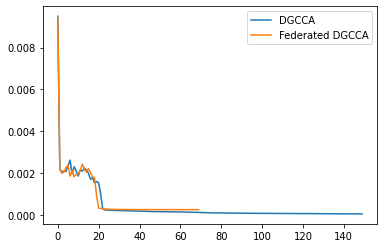

In [20]:
plt.plot(df3['dgcca_loss'])
plt.plot(df_fed['dgcca_loss'])

plt.legend(['DGCCA', 'Federated DGCCA'])